<a href="https://colab.research.google.com/github/EmperorNao/MLHub/blob/main/examples/ipynb/LogisticRegression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model
from math import ceil

In [ ]:
def sgd(x: np.ndarray,
        y: np.ndarray,
        loss_fn, grad_loss_fn,
        lr = 1e-4,
        smart_init=False,
        w: np.ndarray = None,
        lam: float = 0.9,
        eps=1e-6,
        batch_size=1, # менять bs нельзя, данный метод не работает для нескольких элементов в батче
        max_iter=10000,
        logging=False) -> (np.ndarray, float):

    n_features = x.shape[1]
    n_objects = x.shape[0]

    if w is None:
        if not smart_init:
            w = np.zeros(n_features)
            for i in range(n_features):
                w[i] = np.random.normal(0, 1 / (2 * x.shape[0]))

    w = np.expand_dims(w, -1)

    grad_coef = np.asarray([grad_loss_fn(w, np.expand_dims(x[i], axis=0), y[i]) for i in range(n_objects)])
    grad_sum = np.sum(grad_coef, axis=0)


    delta_q = float("inf")
    delta_w = np.array([float("inf")] * n_features)
    loss = loss_fn(w, x, y)
    q = np.sum(loss) / x.shape[0]

    history = []
    iter = 0

    if logging:
        print(f"Iter = {iter}, Loss = {q}")

    while iter < max_iter and abs(delta_q) > eps:# or abs(np.sum(delta_w)) > (eps * n_features)):

        idx_obj = np.random.choice(range(n_objects), size=batch_size)
        x_obj = x[idx_obj,:]
        y_obj = y[idx_obj]

        loss = np.sum(loss_fn(w, x_obj, y_obj)) / x_obj.shape[0]

        grad = grad_loss_fn(w, x_obj, y_obj)
        grad_sum -= grad_coef[idx_obj[0]]
        grad_coef[idx_obj[0]] = grad
        grad_sum += grad_coef[idx_obj[0]]

        delta_w = lr * grad_sum / n_objects
        w = w - delta_w

        new_q = lam * loss + (1 - lam) * q
        delta_q = new_q - q
        q = new_q

        #print(f"iter {iter}\ngrad = {grad}\ndelta w = {delta_w}\ndelta q = {delta_q}\n\n")
        iter += 1
        history.append(q)

        if logging:
            print(f"Iter = {iter}, Loss = {q}")

    return w, q, history


class SGDOptimizer:

    def __init__(self,
                 lr: float =1e-4,
                 smart_init=False,
                 w: np.ndarray = None,
                 lam: float = 0.9,
                 eps = 1e-6,
                 max_iter = 10000,
                 logging=False):

        self.lr = lr
        self.smart_init = smart_init
        self.w = w
        self.lam = lam
        self.eps = eps
        self.max_iter = max_iter
        self.logging = logging

    def fit(self,
            x: np.ndarray,
            y: np.ndarray,
            loss_fn,
            grad_loss_fn,
            get_hist=False) -> (np.ndarray, float):
        # weight and quality

        res = sgd(x, y, loss_fn, grad_loss_fn,
                   self.lr, self.smart_init, self.w, self.lam, self.eps, 1, self.max_iter, self.logging)

        if get_hist:
            return res

        else:
            return res[0], res[1]


In [ ]:

class DimensionsException(Exception):

    def __init__(self, s):
        self.msg = s
        super().__init__()

    def __str__(self):
        return self.msg



def accuracy(y_real: np.ndarray, y_pred: np.ndarray) -> float:

    return np.mean(y_real == y_pred)


def train_test_split(x: np.ndarray,
                     y: np.ndarray,
                     ratio: float = 0) -> ((np.ndarray, np.ndarray), (np.ndarray, np.ndarray)):

    if x.shape[0] != y.shape[0]:
        raise DimensionsException("X and y has different number of objects")

    if 1 < ratio < 0:
        raise ValueError(f"Ratio need to be in [0, 1], provided {ratio}")

    idx_full = range(0, x.shape[0])
    size = ceil(x.shape[0] * ratio)
    idx_train = list(np.random.choice(idx_full, size))
    idx_test = list(set(idx_full).difference(idx_train))

    return (x[idx_train, :], x[idx_test, :]), (y[idx_train], y[idx_test])


In [ ]:

class BinaryClassifier:

    def __init__(self, weights: np.ndarray = None, L2_coefficient: float = 0, logging=False):

        self.weights = weights
        self.L2_coefficient = L2_coefficient if L2_coefficient != 0 else 0.05
        self.logging=logging

    def fit(self, x: np.ndarray, y: np.ndarray, optimizer):

        if x.shape[0] != y.shape[0]:
            raise DimensionsException("X and y has different number of objects")

        n_objects = x.shape[0]
        n_features = x.shape[1] + 1
        ones = 1 * np.ones((n_objects, 1))

        x_padded = np.hstack([x, ones])

        y_transformed = []
        for el_y in y:
            if el_y == 1:
                y_transformed.append(1)
            else:
                y_transformed.append(0)

        w, q, history = optimizer.fit(x_padded, np.expand_dims(y, -1), self.loss, self.grad_loss, get_hist=True)
        self.weights = w

        return history

    def sigmoid(self, x, w):
        # x.shape = m x n
        # y.shape = m x 1
        # w.shape = n x 1

        rev = np.exp(-1 * np.dot(x, w))
        return 1 / (np.ones([x.shape[0], w.shape[1]]) + rev)

    def loss(self, w: np.ndarray, x: np.ndarray, y: np.ndarray):
        # x.shape = m x n
        # y.shape = m x 1
        # w.shape = n x 1

        sigm_res = self.sigmoid(x, w)

        return np.mean(-1 * y * np.log(sigm_res) + \
        -1 * (np.ones_like(y) - y) * np.log(np.ones([x.shape[0], w.shape[1]]) - sigm_res))

    def grad_loss(self, w: np.ndarray, x: np.ndarray, y: np.ndarray):
        # x.shape = m x n
        # y.shape = m x 1
        # w.shape = n x 1

        return np.dot(x.T, (self.sigmoid(x, w) - y))

    def predict(self, x: np.ndarray) -> np.ndarray:

        n_objects = x.shape[0]
        n_features = x.shape[1] + 1
        ones = 1 * np.ones((n_objects, 1))

        x_padded = np.hstack([x, ones])

        pred = self.sigmoid(x_padded, self.weights)
        if self.logging:
            print(self.weights)
            print(pred)

        return (pred >= 0.5).astype(dtype="int").squeeze(-1)

In [ ]:

def generate_clouds(scale):

    N = 200
    N2 = 25

    n_pos = int(N // 2 + np.random.randint(-N2, N2))
    n_neg = int(N // 2 + np.random.randint(-N2, N2))

    pos_x = 10
    pos_y = 10

    neg_x = -10
    neg_y = 10

    pos_pairs = np.array([np.array(
        [pos_x + np.random.normal(scale=scale), pos_y + np.random.normal(scale=scale)])
        for i in range(0, n_pos)])

    pos_answers = np.array([1] * n_pos)

    neg_pairs = np.array([np.asarray(
        [neg_x + np.random.normal(scale=scale), neg_y + np.random.normal(scale=scale)])
        for i in range(0, n_neg)])
    neg_answers = np.array([0] * n_neg)

    x = np.vstack([pos_pairs, neg_pairs])
    y = np.hstack([pos_answers, neg_answers])

    idx = np.random.permutation([i for i in range(x.shape[0])])

    x = x[idx]
    y = y[idx]

    return x, y


def binlog_test():

    for scale in [3, 5, 9]:


        optim = SGDOptimizer(lr=1e-4, max_iter=10000, lam=0.80)
        simple = BinaryClassifier()
        sklearn = linear_model.LogisticRegression()

        x, y = generate_clouds(scale)
        x_pair, y_pair = train_test_split(x, y, ratio=0.75)

        x_train, x_test = x_pair
        y_train, y_test = y_pair

        simple.fit(x_train, y_train, optim)
        sklearn.fit(x_train, y_train)

        y_pred_simple = simple.predict(x_test)
        y_pred_sklearn = sklearn.predict(x_test)

        print(f"Scale = {scale}")
        print(f"ACC on SLKEARN = {accuracy(y_test, y_pred_sklearn)}")
        print(f"ACC on our LR = {accuracy(y_test, y_pred_simple)}")

        fig = plt.figure(figsize = (12, 8))

        idx_one = y_test == 1
        idx_zero = y_test == 0

        plt.title("Two classes")

        plt.scatter(x_test[idx_one, 0], x_test[idx_one, 1], color="red", s=50)

        plt.scatter(x_test[idx_zero, 0], x_test[idx_zero, 1], color="blue", s=50)

        b = simple.weights[2]
        w1 = simple.weights[0]
        w2 = simple.weights[1]
        x = [i for i in range(-15, 15)]
        y = [-i * w1 / w2 - b / w2 for i in x]
        plt.plot(x, y, color="black")
        plt.ylim([-25, 25])

        plt.show()

Scale = 3
ACC on SLKEARN = 1.0
ACC on our LR = 1.0


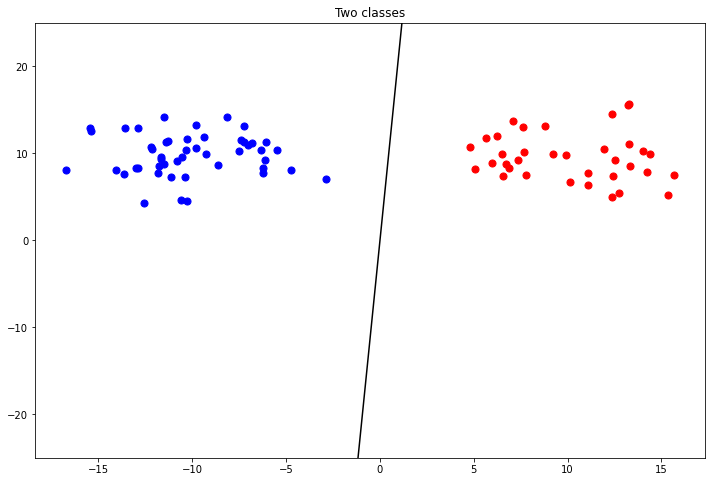

Scale = 5
ACC on SLKEARN = 0.9772727272727273
ACC on our LR = 0.9886363636363636


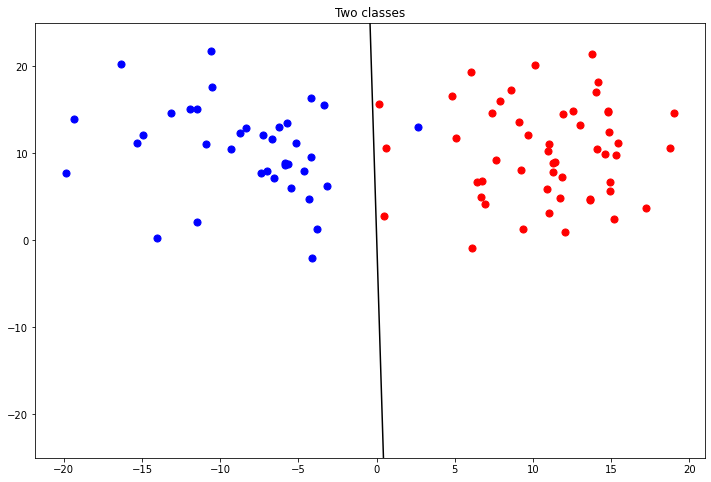

Scale = 9
ACC on SLKEARN = 0.8865979381443299
ACC on our LR = 0.865979381443299


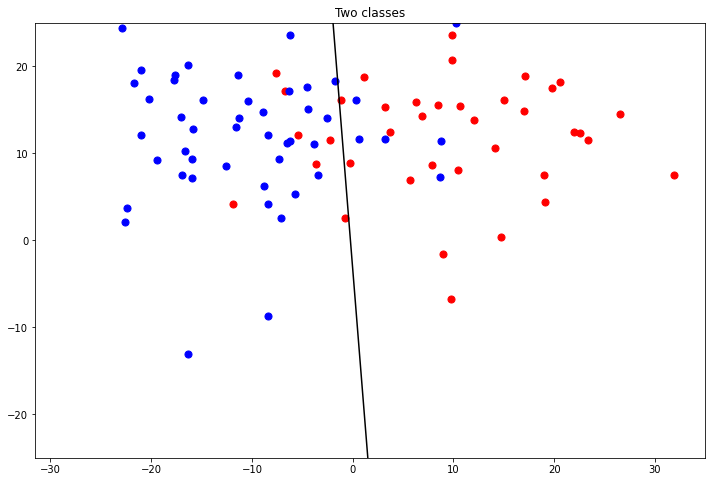

In [ ]:
binlog_test()